# Survival Regression Analysis on Customer Churn

In this post, we will analyze Telcon's Customer Churn Dataset and figure out what factors contribute to churn. By definition, a customer churn when they unsubscribe or leaves a service. With survival analysis, the customer churn event is analogus to "death". Armed with survival function, we will caculate what is the optimum monthly rate to maximize a customer lifetime value. 

In [50]:
###############
### Library ###
###############

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.mixture import GaussianMixture
from lifelines import CoxPHFitter
from lifelines.plotting import plot_lifetimes
%matplotlib inline

In [54]:
######################
### Plot Functions ###
######################

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [14, 8]
plt.rcParams['lines.linewidth'] = 2.5

def add_title(ax, title, subtitle, x):
    y_min, y_max = ax.get_ylim()
    y_title = (y_max - y_min)*0.085 + y_max
    y_subtitle = (y_max - y_min)*0.025 + y_max
    ax.text(x, y_subtitle, subtitle, fontsize=15, alpha=.75)
    ax.text(x, y_title, title, fontsize=22, alpha=.85, weight='bold')
    return ax
    
def config_ticks(ax):
    ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
    return ax
    
def add_title_fig(fig, title, subtitle, x, y_title, y_subtitle):
    fig.text(x, y_title, title, fontweight='bold', fontsize=22, alpha=.85)
    fig.text(x, y_subtitle, subtitle,  fontsize=15, alpha=.75)
    return fig

def add_yaxis(ax, y=0):
    return ax.axhline(y=y, color='black', linewidth=1.3, alpha=0.7)

def convert_cat(df):
    df = df.copy()
    
    internet_dict = {'No': 0, 'Yes': 1, 'No internet service': 0}
        
    out = df.assign(
        Partner=df.Partner == 'Yes',
        MultipleLines=df.MultipleLines.map({'No': 0, 'Yes': 1, 'No phone service': 0}),
        InternetService=df.InternetService.map({'Fiber optic': 1, 'DSL': 1, 'No': 0}),
        OnlineSecurity=df.OnlineSecurity.map(internet_dict),
        OnlineBackup=df.OnlineBackup.map(internet_dict),
        DeviceProtection=df.DeviceProtection.map(internet_dict),
        TechSupport=df.TechSupport.map(internet_dict),
        StreamingTV=df.StreamingTV.map(internet_dict), 
        StreamingMovies=df.StreamingMovies.map(internet_dict),
        Contract=df.Contract.map({'Month-to-month': 1, 'One year': 12, 'Two year': 24}),
        PaperlessBilling=df.PaperlessBilling == 'Yes' ,
        automatic_payment=df.PaymentMethod.str.contains("automatic"),
        Churn=df.Churn == 'Yes'
    ).drop(columns=['gender', 'PaymentMethod', 'customerID', 'TotalCharges', 'SeniorCitizen', 'Dependents', 'PhoneService'])
    return out

def plot_boolean_covariate(fitter, name, ax=None):
    ax = fitter.plot_covariate_groups(name, [0, 1], ax=ax)
    _ = ax.set_ylabel("Survival Function")
    _ = ax.set_xlabel("Time (months)")
    _ = ax.set_xlim((-1, 73))
    handles, labels = ax.get_legend_handles_labels()
    handles[0].set_color('red')
    handles[1].set_color('green')
    handles[2].set_color('black')
    handles[0], handles[1] = handles[1], handles[0]
    ax.legend(handles, ['True', 'False', 'baseline survival'])
    return ax

def get_expected_value(fitter, monthly_charges):
    X = pd.concat([fitter._norm_mean.to_frame().T])
    output = np.empty_like(monthly_charges, dtype=np.float32)
    for i, mc in enumerate(monthly_charges):
        X['MonthlyCharges'] = mc
        output[i] = mc*fitter.predict_expectation(X).iloc[0,0]
    return output

# Overview of the dataset

The dataset consist of many features associated with a customer. For regular survial analysis we only need the tenure and churn features. The tenure is the number of time a customer has stayed with the service. The churn column is a boolean feature that states if the customer churned or not.

In [9]:
df = pd.read_csv(r'C:\Users\jing.o.li\Desktop\WA_Fn-UseC_-Telco-Customer-Churn.csv',sep=',')
df[['Churn','tenure']].head()

,Churn,tenure
0,No,1
1,No,34
2,Yes,2
3,No,45
4,Yes,2


For customers that did not churn yet, they may churn in the future. Since this is data from the future, it is not recorded in our dataset. Datasets exhibiting this behavior are called right-censored. 

# Loading data and fitting the model

We use lifelines project to train a Cox's Proportional Hazard Model. This model is able to do regression on the other features in the dataset.

In [21]:
events = convert_cat(df)
events.to_csv(r'C:\Users\jing.o.li\Desktop\Telco-Customer-Churn.csv', sep=',')
cph = CoxPHFitter()
cph.fit(df = events, duration_col = 'tenure', event_col = 'Churn')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 7043 observations, 5174 censored>
      duration col = 'tenure'
         event col = 'Churn'
number of subjects = 7043
  number of events = 1869
    log-likelihood = -13889.59
  time fit was run = 2019-06-09 18:59:43 UTC

---
                   coef exp(coef)  se(coef)      z      p  -log2(p)  lower 0.95  upper 0.95
Partner           -0.53      0.59      0.05 -10.60 <0.005     84.80       -0.63       -0.44
MultipleLines     -0.52      0.59      0.06  -9.22 <0.005     64.87       -0.63       -0.41
InternetService    0.87      2.39      0.13   6.86 <0.005     37.04        0.62        1.12
OnlineSecurity    -0.72      0.49      0.07 -10.99 <0.005     90.84       -0.85       -0.59
OnlineBackup      -0.71      0.49      0.06 -12.92 <0.005    124.44       -0.82       -0.61
DeviceProtection  -0.38      0.69      0.06  -6.83 <0.005     36.81       -0.49       -0.27
TechSupport       -0.47      0.62      0.06  -7.29 <0.005     41.52       -0.60       -0.34
St

Interpreting the results:

    - coef: the coefficient
    - exp(coef): estimate of hazard ratio
    - se: standard deviation of the coefficient
    - z: z-score
    - p: p-value
    - log2(p): log base 2 of p-value
    - lower/upper 0.95: confidence intervals
    - concordance: a measure of predictive power for classification problems. from 0 to 1, and above 0.6 are considered good fits.
    - likelihood ratio test: this is a measure of how likely it is that the coefficient are not zero

Here we noticed that InternetService, and PaperlessBilling are the only two features with positive coefficients and above 1 hazard ratios. This observation indicates that they are the only factors that positively contribute to the churn event of a customer.

    - InternetService is more severe than PaperlessBilling
    - If a customer is 1 under the InternetService column than the risk of churn for that customer is two times more than customer without internet service. 

With the fitted survival regression model, we take a look at how each feature affects the survival function.

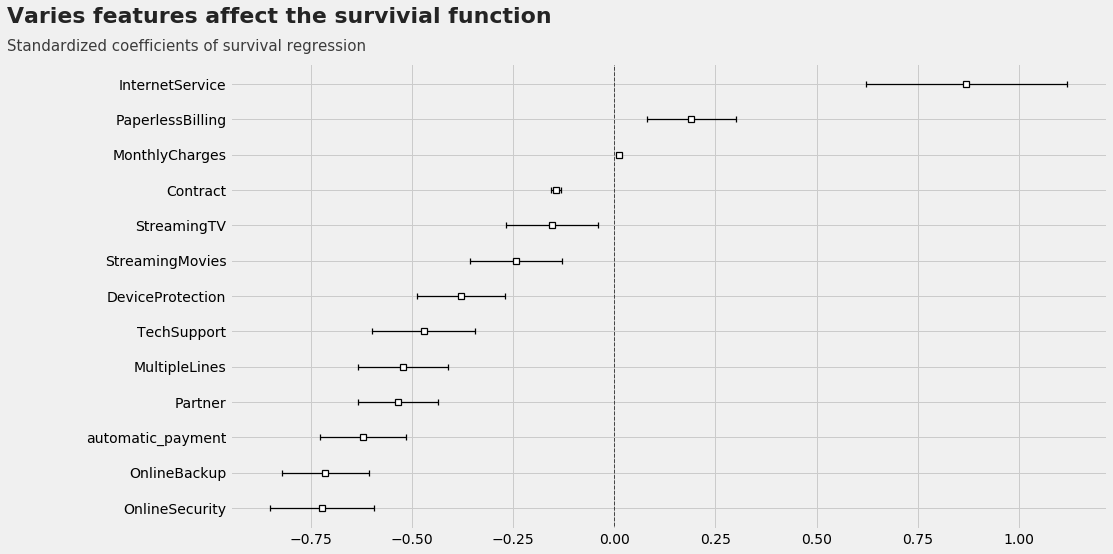

In [41]:
ax = cph.plot()
ax = add_title(ax, "Varies features affect the survivial function", "Standardized coefficients of survival regression", -1.5)
_ = ax.set_xlabel("")

The cofficients gives a sense of the impact of each feature. The closer the cofficient is to zero, the less effect it has on the survivial function. 

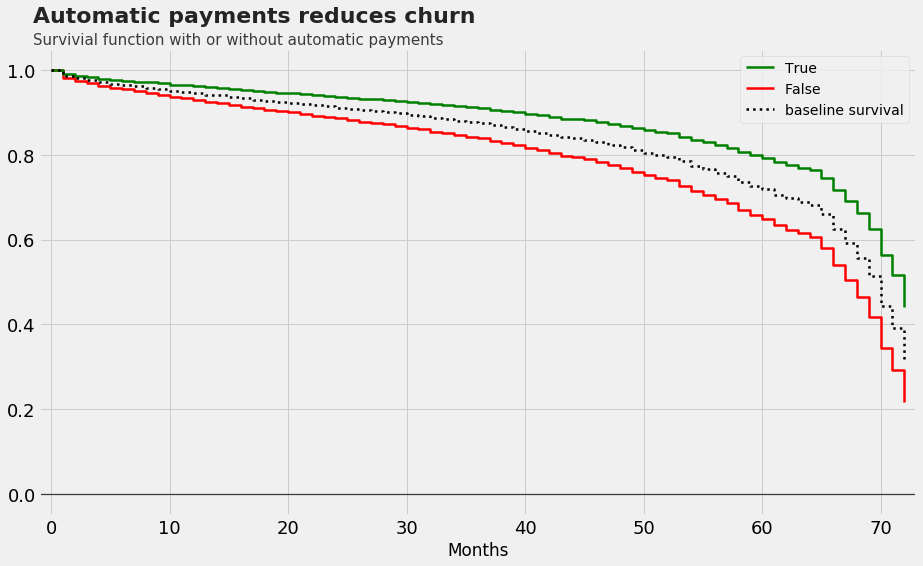

In [40]:
ax = plot_boolean_covariate(cph, "automatic_payment")
ax.set_xlabel("Months")
ax.set_ylabel("")
ax = add_title(ax, "Automatic payments reduces churn", "Survivial function with or without automatic payments", -1.5)
_ = config_ticks(ax)
_ = add_yaxis(ax)

The green and red curve represents the survivial function when automatic payment is on or off respectively. The result is expected, the green curve is always above the red curve, i.e. enabling automatic payments increaese the probability of survivial. The other boolean features also help with customer churn

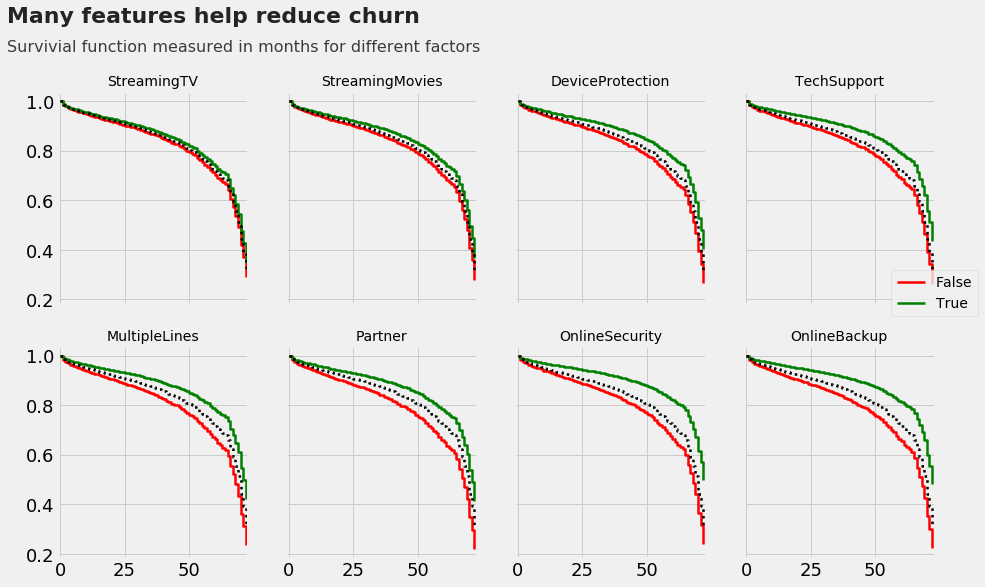

In [47]:
center_names = [
    "StreamingTV", "StreamingMovies", "DeviceProtection", "TechSupport", 
    "MultipleLines", "Partner", "OnlineSecurity", "OnlineBackup"
]
fig, axes = plt.subplots(2, 4, sharey=True, sharex=True)
for name, ax in zip(center_names, axes.flatten()):
    ax = plot_boolean_covariate(cph, name, ax=ax)
    ax.set_title(name, fontdict={'size': 14})
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.legend_.remove()
    _ = config_ticks(ax)
    
fig.text(0.03, 1, "Many features help reduce churn", fontweight='bold', fontsize=22, alpha=.85)
fig.text(0.03, 0.95, "Survivial function measured in months for different factors",  fontsize=16, alpha=.75)
_ = fig.legend(labels=('False', 'True'), loc="center right", fancybox=True, fontsize=14)

The survivial function for various contract lengths blow shows the expected result, i.e. longer contracts prevents customers from leaving.

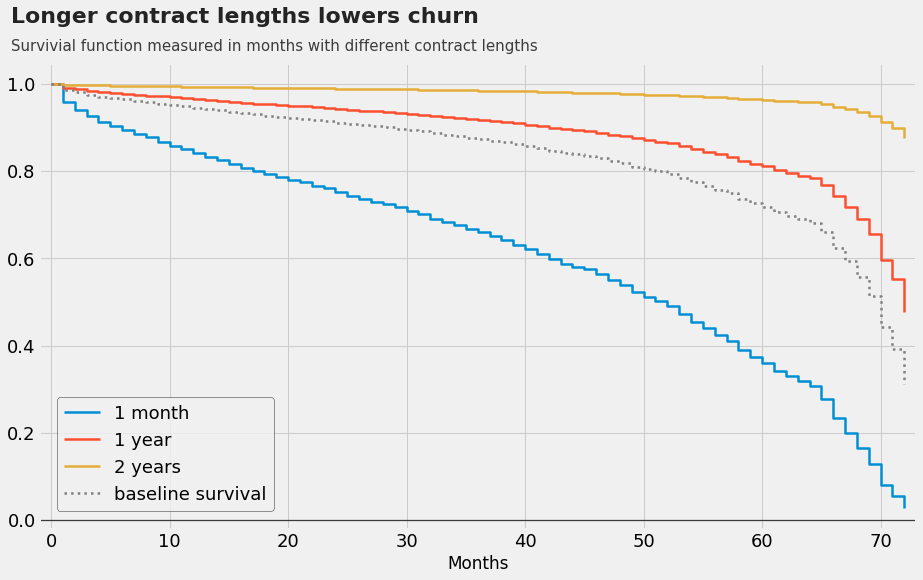

In [48]:
contract_lengths = [1, 12, 24]
ax = cph.plot_covariate_groups('Contract', contract_lengths)
_ = ax.set_xlim((-1, 73))
_ = ax.set_xlabel("Months")
_ = add_yaxis(ax)
handles, labels = ax.get_legend_handles_labels()
handles[-1].set_color('gray')
_ = add_title(ax, "Longer contract lengths lowers churn", "Survivial function measured in months with different contract lengths", -3.4)
_ = ax.legend(handles, ['1 month', '1 year', '2 years'] + ['baseline survival'], edgecolor='black', loc=(0.02, 0.04), 
              fontsize=18)
_ = config_ticks(ax)

# Deep Dive Into Monthly Rates

In this section, we will calculate how much to charge a customer to maximize lifetime value. First, we visualize the monthly rate distrubution.

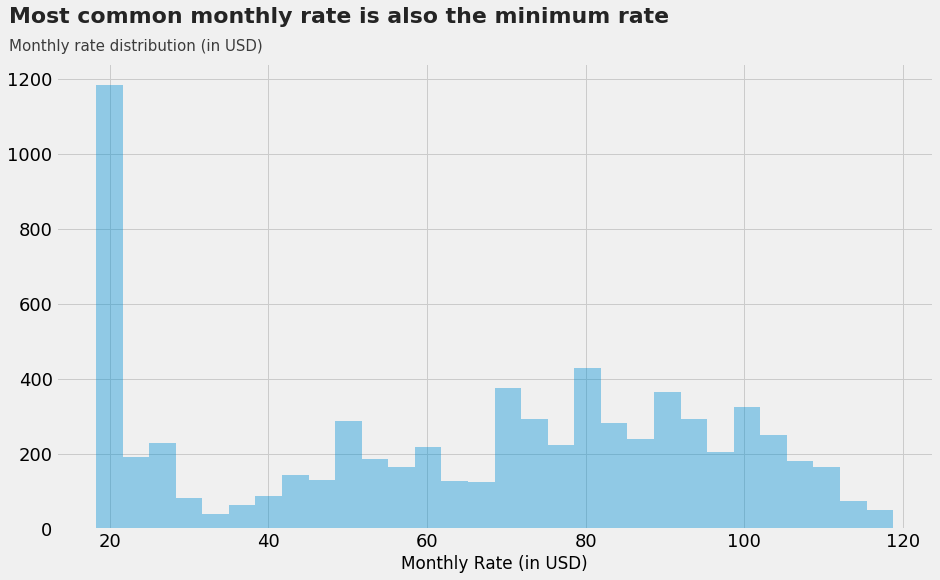

In [49]:
ax = sns.distplot(df.MonthlyCharges, bins=30, kde=False)
ax.set_xlabel("Monthly Rate (in USD)")
add_title(ax, "Most common monthly rate is also the minimum rate", "Monthly rate distribution (in USD)", 7.3)
_ = add_yaxis(ax)
_ = config_ticks(ax)

Next, we plot the survival function for different monthly rates

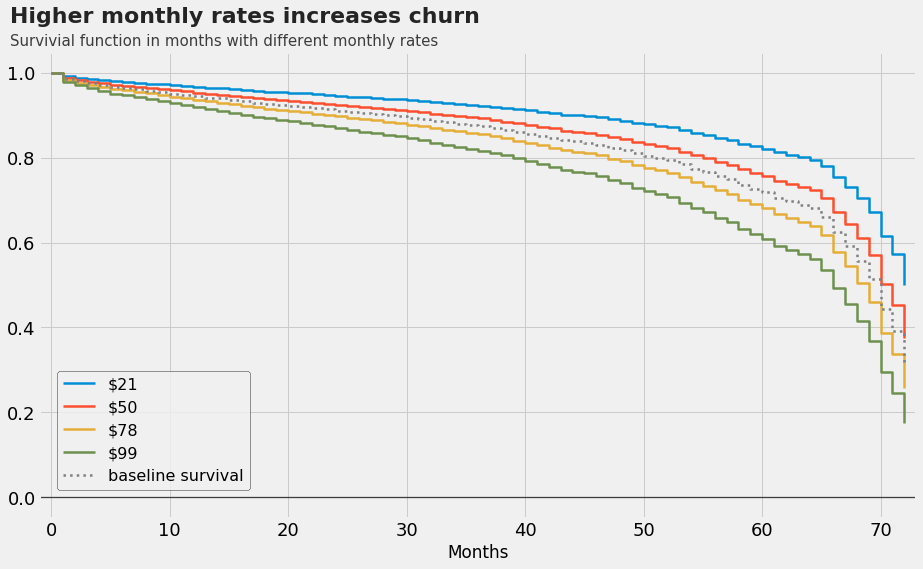

In [58]:
gm = GaussianMixture(n_components=4)
gm.fit(df[['MonthlyCharges']])
monthly_means = sorted(gm.means_[:,0].tolist())

ax = cph.plot_covariate_groups('MonthlyCharges', monthly_means)
_ = ax.set_xlabel("Months")
_ = ax.set_xlim((-1, 73))
add_title(ax, "Higher monthly rates increases churn", "Survivial function in months with different monthly rates", -3.5)
handles, labels = ax.get_legend_handles_labels()
handles[-1].set_color('gray')

_ = add_yaxis(ax)
_ = config_ticks(ax)
_ = ax.legend(handles, [f"${v:.0f}" for v in monthly_means]+ ['baseline survival'], loc=(0.02, 0.06), 
              edgecolor='black', fontsize=16)

Again the result is expected, the higher the monthly rate, the lower the survivial function. With these survivial functions, we can calculate the average number of months a customer will stay for different monthly rate. Multiplying the average number of months with the monthly rate, gives the lifetime value of a customer at each price point.

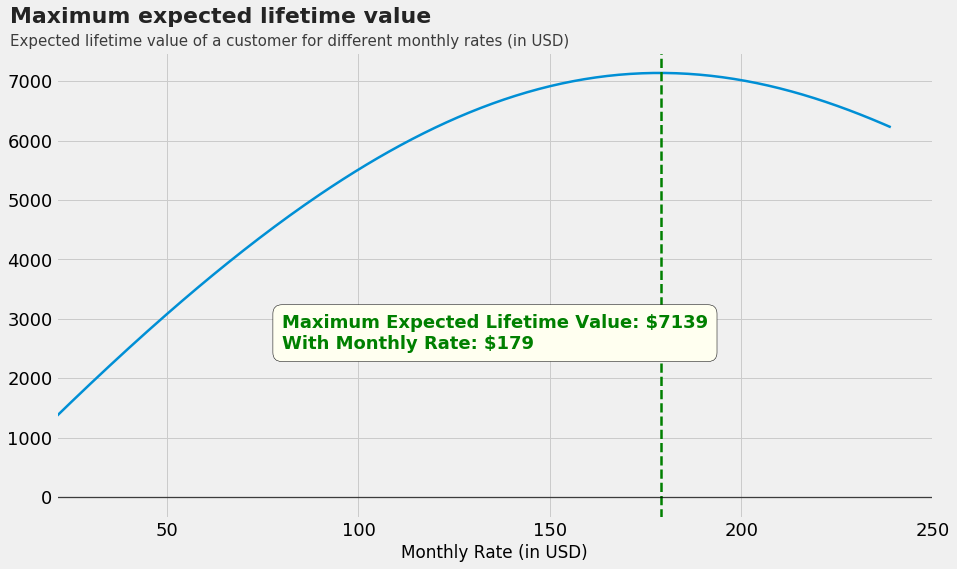

In [59]:
monthly_charges = np.arange(20, 240) 
lifetime_value = get_expected_value(cph, monthly_charges)
lifetime_max_arg = np.argmax(lifetime_value)
lifetime_max = np.max(lifetime_value)
monthly_charge_max = monthly_charges[lifetime_max_arg]
fig, ax = plt.subplots()
ax.plot(monthly_charges, lifetime_value)
ax.axvline(x=monthly_charge_max, c='green', ls='dashed')
ax.set_xlabel("Monthly Rate (in USD)")
ax.text(80, 2500, f'Maximum Expected Lifetime Value: ${lifetime_max:.0f}\nWith Monthly Rate: ${monthly_charge_max:.0f}', color='green', 
        bbox=dict(facecolor='ivory', edgecolor='black', boxstyle='round,pad=0.5'), fontdict={'size': 18, 'weight': "bold"})
ax.set_xlim((21, 250))
add_title(ax,'Maximum expected lifetime value', 'Expected lifetime value of a customer for different monthly rates (in USD)', 9)
_ = config_ticks(ax)
_ = add_yaxis(ax)